In [25]:
# import the packages
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import geopandas as gpd
from collections import Counter
from statistics import mode
import datetime
from sklearn.metrics.pairwise import cosine_similarity
import geopandas
import rtree
import seaborn as sns
import haversine as hs


# 1 Import data

In [2]:
# import the data into pandas dataframes
hvc_am0 = pd.read_csv("../ACRM-GROUP-13/data/HVC_AM0.csv", sep=";")
hvc_ar0 = pd.read_csv("../ACRM-GROUP-13/data/HVC_AR0.csv", sep=";")
hvc_customer_reviews = pd.read_csv("../ACRM-GROUP-13/data/HVC_CUSTOMER_REVIEWS.csv", sep=";")
hvc_depot = pd.read_csv("../ACRM-GROUP-13/data/HVC_DEPOT.csv", sep=";")
hvc_hvdayofweek = pd.read_csv("../ACRM-GROUP-13/data/HVC_HVDAYOFWEEK.csv", sep=";")
hvc_hvposition = pd.read_csv("../ACRM-GROUP-13/data/HVC_HVPOSITION_CORRECT.csv", sep=";")
hvc_hvroutetemplate = pd.read_csv("../ACRM-GROUP-13/data/HVC_HVROUTETEMPLATE.csv", sep=";")
hvc_hvvisitoutcome = pd.read_csv("../ACRM-GROUP-13/data/HVC_HVVISITOUTCOME.csv", sep=";")
hvc_hvvisitresult = pd.read_csv("../ACRM-GROUP-13/data/HVC_HVVISITRESULT.csv", sep=";")
hvc_so0 = pd.read_csv("../ACRM-GROUP-13/data/HVC_SO0.csv", sep=";")
hvc_visitresultdetails = pd.read_csv("../ACRM-GROUP-13/data/HVC_VISITRESULTDETAILS.csv", sep=";")

In [3]:
#Data conversion
hvc_hvdayofweek["HVDAYOFWEEK_NRID"] = hvc_hvdayofweek["HVDAYOFWEEK_NRID"].astype(int)
hvc_hvroutetemplate["HVROUTETEMPLATE_NRID"] = hvc_hvroutetemplate["HVROUTETEMPLATE_NRID"].astype(int)
hvc_hvroutetemplate["HVDAYOFWEEK_NRID"] = hvc_hvroutetemplate["HVDAYOFWEEK_NRID"].astype(int)
hvc_hvroutetemplate["WEEKORDER"] = hvc_hvroutetemplate["WEEKORDER"].astype(int)
hvc_hvvisitoutcome["HVOUTCOME_NRID"] = hvc_hvvisitoutcome["HVOUTCOME_NRID"].astype(int)
hvc_visitresultdetails["HVVISITRESULT_NRID"] = hvc_visitresultdetails["HVVISITRESULT_NRID"].astype(int)
hvc_so0["SO0_NRID"] = hvc_so0["SO0_NRID"].astype(int)
hvc_so0["HVROUTETEMPLATE_NRID"] = hvc_so0["HVROUTETEMPLATE_NRID"].astype(int)
hvc_hvvisitresult["DATEONLY"] = pd.to_datetime(hvc_hvvisitresult["DATEONLY"])
hvc_hvvisitresult["VISITDATE"] = pd.to_datetime(hvc_hvvisitresult["VISITDATE"])

# 2 Advanced Analysis

## 2.5 Are there factors that the company can change in order to decrease the churning rate?

In [4]:
def season_of_date(date):
    year = str(date.year)
    seasons = {'Spring': pd.date_range(start='21/03/'+year, end='20/06/'+year),
               'Summer': pd.date_range(start='21/06/'+year, end='20/09/'+year),
               'Autumn': pd.date_range(start='21/09/'+year, end='20/12/'+year)}
    if date in seasons['Spring']:
        return 'Spring'
    if date in seasons['Summer']:
        return 'Summer'
    if date in seasons['Autumn']:
        return 'Autumn'
    else:
        return 'Winter'

In [7]:
#Check if the customer is visited at the right moment
#comparing amounts of open door but no purchase on a certain date with the preferred time for visits
hvc_hvvisitresult_nothingneeded = hvc_hvvisitresult[hvc_hvvisitresult["HVOUTCOME_NRID"] == 0]
hvc_hvvisitresult_nothingneeded.drop(axis = 1,labels = "PAYMENTTERM")

hvc_hvvisitresult_nothingneeded_so0 = pd.merge(hvc_hvvisitresult_nothingneeded, hvc_so0, on = "SO0_NRID")

hvc_hvvisitresult_nothingneeded_so0.drop(axis = 1, labels = "PAYMENTTERM")

#Christmas
hvc_hvvisitresult_nothingneeded_so0_christmas = hvc_hvvisitresult_nothingneeded_so0[hvc_hvvisitresult_nothingneeded_so0["SEASON_TYPE"] == "Christmas"]

christmas_false = []
for index, row in hvc_hvvisitresult_nothingneeded_so0_christmas.iterrows():
    if(row.DATEONLY.month != 12):
        christmas_false.append(index)
christmas_wrongproportion = int((len(christmas_false)/len(hvc_hvvisitresult_nothingneeded_so0_christmas)*100))
print("Christmas: ", christmas_wrongproportion)

#Function
def season_proportion(season):
    hvc_hvvisitresult_nothingneeded_so0_Season = hvc_hvvisitresult_nothingneeded_so0[hvc_hvvisitresult_nothingneeded_so0["SEASON_TYPE"] == season]

    Season_false = []
    for index, row in hvc_hvvisitresult_nothingneeded_so0_Season.iterrows():
        if(season_of_date(row.DATEONLY) == season):
            Season_false.append(index)
    Season_wrongproportion = int((len(Season_false)/len(hvc_hvvisitresult_nothingneeded_so0_Season)*100))
    print(season + ": ", Season_wrongproportion)
    return Season_wrongproportion
    
    
summer_wrongproportion = season_proportion("Summer")
winter_wrongproportion = season_proportion("Winter")

Christmas:  89
Summer:  25
Winter:  0


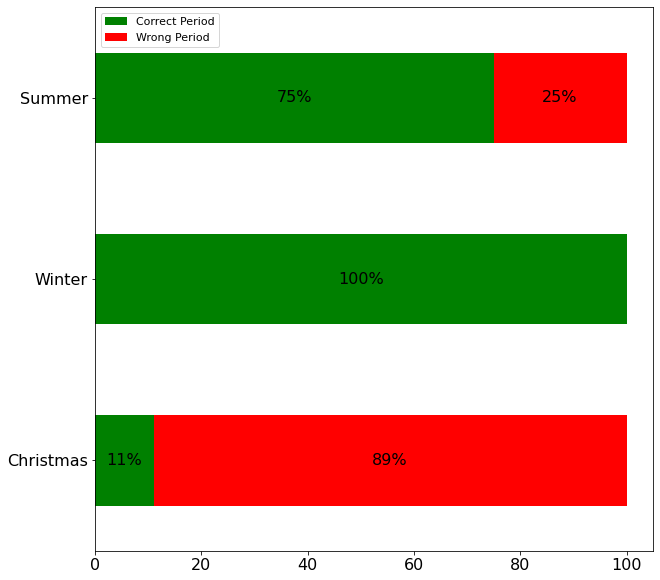

In [8]:
## Making a horizontal stacked bar chart
from matplotlib.colors import LinearSegmentedColormap

#making a df
data = [['Christmas', 100 - christmas_wrongproportion, christmas_wrongproportion], ['Winter', 100 - winter_wrongproportion, winter_wrongproportion], ['Summer', 100 - summer_wrongproportion, summer_wrongproportion]]
df = pd.DataFrame(data, columns = ['Season_Types', 'Wrong_Period',"Correct_Period"])

## making plot
ax = df.plot(kind='barh', stacked=True, figsize=(10, 10), color = ["green","red"])

for c in ax.containers:
    
    # customize the label to account for cases when there might not be a bar section
    labels = [f'{w:.0f}%' if (w := v.get_width()) > 0 else '' for v in c ]
    
    # set the bar label
    ax.bar_label(c, labels=labels, label_type='center', fontsize = 16)
    
    
ax.legend(["Correct Period", "Wrong Period"],loc="upper left", fontsize = 11)
plt.xticks([0,20,40,60,80,100], fontsize = 16)
plt.yticks(np.arange(3), df["Season_Types"], fontsize = 16)
plt.savefig('./Graphs/Correct_Visit_Period.png')
plt.show()

In [10]:
# Turnover customers
hvc_hvvisitresult_nothingneeded = hvc_hvvisitresult[hvc_hvvisitresult["HVOUTCOME_NRID"] == 0]
visit_turnover = (len(hvc_hvvisitresult_nothingneeded)/len(hvc_hvvisitresult))*100
visit_turnover

38.99715076014392

In [26]:
# check if the customer closed door is visited between 9 and 17

hvc_hvvisitresult_nothome = hvc_hvvisitresult[hvc_hvvisitresult["HVOUTCOME_NRID"] == 1]
hvc_hvvisitresult_nothome.drop(axis = 1,labels = "PAYMENTTERM")

Correct_Time = []
Wrong_Time = []

starttime= datetime.time(9,0,0)
endtime = datetime.time(17,0,0)

for index, row in hvc_hvvisitresult_nothome.iterrows():
    if(row.VISITDATE.time() > starttime and row.VISITDATE.time() < endtime):
        Wrong_Time.append(index)
Wrong_Time_proportion = int(100*(len(Wrong_Time)/len(hvc_hvvisitresult_nothome)))
print(Wrong_Time_proportion)

81


## 3.2 Product Family 

In [60]:
# get the number of products in each product family
products_per_family = hvc_ar0.groupby("FAMILY")["AR0_NRID"].count().reset_index()

In [65]:
#making the correct table
hvc_ar0_visitresultdetails = pd.merge(hvc_ar0, hvc_visitresultdetails)
hvc_ar0_visitresultdetails

#calculating the revenue
revenue = hvc_ar0_visitresultdetails["QUANTITY"] * hvc_ar0_visitresultdetails["PRICE"]
hvc_ar0_visitresultdetails["REVENUE"] = revenue
agg_dict = {"REVENUE": np.sum}
hvc_revenue = hvc_ar0_visitresultdetails.groupby("AR0_NRID").agg(agg_dict)
hvc_revenue_top = hvc_revenue.sort_values("REVENUE", ascending = False).head(5)

agg_dict = {"REVENUE": np.sum}
hvc_revenue_family = hvc_ar0_visitresultdetails.groupby("FAMILY").agg(agg_dict)
hvc_revenue_sorted = hvc_revenue_family.sort_values("REVENUE", ascending = False)
hvc_revenue_sorted

,REVENUE
FAMILY,
Hand Ice,399042.2
Scoop Ice,279254.7
Cups,110634.7
Ice Cakes,62868.9
Assortments,61107.9
Individual Dessert,54172.2
Meals,39075.6
Coffee,31738.7
Garniture,13203.1


In [66]:
products_per_family.sort_values("AR0_NRID")
products_per_family_index = products_per_family.set_index("FAMILY").reindex(hvc_revenue_sorted.index)

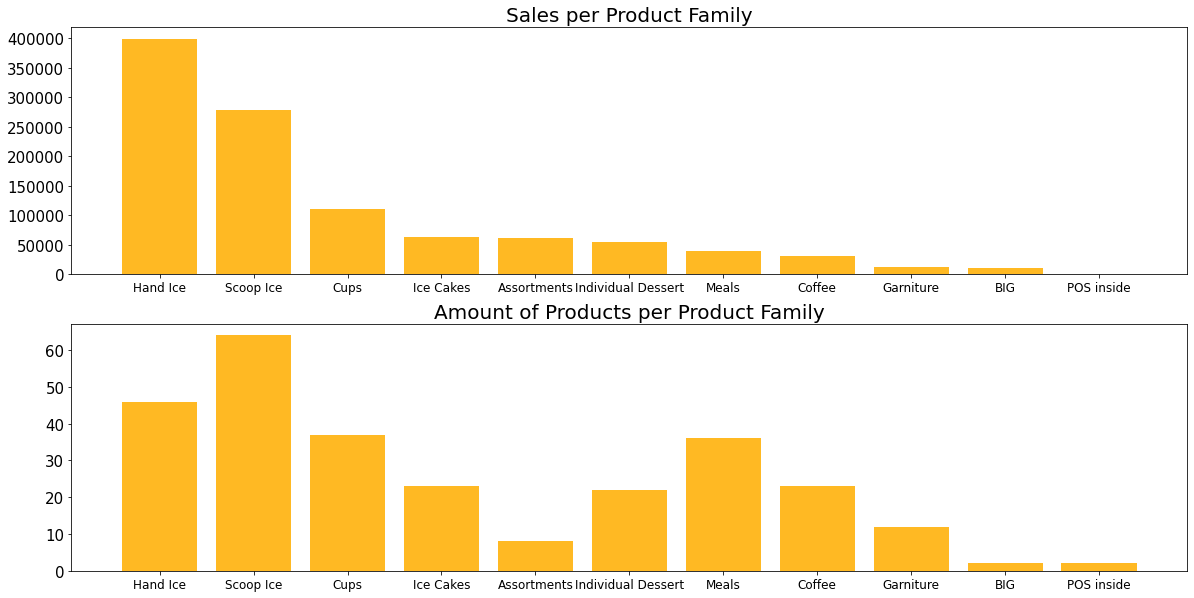

In [80]:
# create subplot
plt.figure(figsize = (20,10))
plt.subplot(2,1,1)
# plot barplot
plt.bar(x=range(11), height=hvc_revenue_sorted["REVENUE"], label = "Revenue", color = '#ffb923')
plt.set_color = ("#ffb923")
# set xticks
family_names = []
for index in hvc_revenue_sorted.index:
    family_names.append(index)
plt.xticks(range(11), family_names, fontsize = 12)
plt.yticks(fontsize = 15)
# define title
plt.title("Sales per Product Family", fontsize = 20)

plt.subplot(2,1,2)
# plot barplot
plt.bar(x=range(11), height=products_per_family_index["AR0_NRID"], label = "Products per family", color = '#ffb923')
plt.set_color = ("#ffb923")
# set xticks
plt.xticks(range(11), family_names, fontsize = 12)
plt.yticks(fontsize = 15)
# define title
plt.title("Amount of Products per Product Family", fontsize = 20)
plt.savefig('./Graphs/productfamily.png')
plt.show()



In [68]:
# check the proportion of sold products

hvc_revenue_family

,REVENUE
FAMILY,
Assortments,61107.9
BIG,10240.0
Coffee,31738.7
Cups,110634.7
Garniture,13203.1
Hand Ice,399042.2
Ice Cakes,62868.9
Individual Dessert,54172.2
Meals,39075.6


In [69]:
#check the top products per family so we can drop certain products that do not generate enough
# sidenote with the graph about products per family and revenue per family

agg_dict = {'REVENUE': np.sum}
hvc_revenue_product = hvc_ar0_visitresultdetails.groupby('AR0_NRID').agg(agg_dict)

hvc_revenue_product_family = pd.merge(hvc_revenue_product,hvc_ar0, on = "AR0_NRID")
hvc_revenue_product_family = hvc_revenue_product_family[hvc_revenue_product_family['FAMILY'].notna()]

def topproductsperfamily(specificfamily):
    hvc_revenue_product_family_Specificfamily = hvc_revenue_product_family[hvc_revenue_product_family["FAMILY"] == specificfamily].sort_values("REVENUE", ascending = False)
    total_revenue_family = hvc_revenue_product_family[hvc_revenue_product_family["FAMILY"] == specificfamily]["REVENUE"].sum()
    frequency_family = []
    for index, row in hvc_revenue_product_family_Specificfamily.iterrows():
        frequency_family.append(round((100 * row.REVENUE)/total_revenue_family,2))
    hvc_revenue_product_family_Specificfamily["FREQUENCY_OF_REVENUE"] = frequency_family
    hvc_revenue_product_family_Specificfamily.set_index("AR0_NRID", inplace = True)
    return hvc_revenue_product_family_Specificfamily[["REVENUE", "FREQUENCY_OF_REVENUE"]]
scoop_ice = topproductsperfamily("Scoop Ice")
scoop_ice[scoop_ice["FREQUENCY_OF_REVENUE"] < 0.1]


,REVENUE,FREQUENCY_OF_REVENUE
AR0_NRID,,
290318679,258.3,0.09
23702,257.3,0.09
23704,166.0,0.06
23701,141.1,0.05
23703,107.9,0.04
17811288175050,49.8,0.02
18424244393052,33.2,0.01
23712,33.2,0.01
19864988676644,32.4,0.01


## 3.3 Recommendation Engine

#### Preparations

In [47]:
#making the necessary tables
hvc_visitresult_visitresultdetails_so0 = pd.merge(pd.merge(hvc_hvvisitresult, hvc_so0, on = "SO0_NRID"), hvc_visitresultdetails, on = "HVVISITRESULT_NRID")
hvc_visitresult_visitresultdetails_so0_ar0 = pd.merge(hvc_visitresult_visitresultdetails_so0, hvc_ar0, on = "AR0_NRID")
hvc_visitresult_visitresultdetails_so0_ar0_routetemplate = pd.merge(hvc_visitresult_visitresultdetails_so0_ar0, hvc_hvroutetemplate)
hvc_visitresult_visitresultdetails_so0_ar0_routetemplate
def productsregionfct(region):
    hvc_visitresult_visitresultdetails_so0_ar0_routetemplate_sortedquantity = hvc_visitresult_visitresultdetails_so0_ar0_routetemplate[hvc_visitresult_visitresultdetails_so0_ar0_routetemplate["REGION"] == region].sort_values(by = "QUANTITY")
    quantity_act= {"QUANTITY" : np.sum}
    quantity_grouped = hvc_visitresult_visitresultdetails_so0_ar0_routetemplate_sortedquantity.groupby("AR0_NRID").agg(quantity_act)
    quantity_grouped_top = quantity_grouped.sort_values(by = "QUANTITY", ascending = False).head(5)
    regionlist = []
    for index in quantity_grouped_top.index:
        regionlist.append(index)
    return regionlist

In [5]:
transactions_details_df = pd.merge(left=hvc_hvvisitresult, right=hvc_visitresultdetails, on="HVVISITRESULT_NRID", how="inner")

In [6]:
# put the column "AR0_NRID" of hvc_visitresultdetails_correlatedproducts in a list 
# so that it is easier to work with

# get unique transactions
trans_ids = transactions_details_df["HVVISITRESULT_NRID"].unique().tolist()

# initialize container
trans_products = []

# loop through all the transactions
for trans_id in trans_ids:
    # get unique products that were bought during transaction
    products = transactions_details_df[transactions_details_df["HVVISITRESULT_NRID"] == trans_id]["AR0_NRID"].unique().tolist()
    # add to container
    trans_products.append(products)

In [8]:
#function to get the most correlated product of a product
def get_correlated_product(product_id):    
    # initialize empty container
    other_products = []
    # loop through the transactions
    for products in trans_products:
        # check if product_id was bought in transaction
            if product_id in products:
            # loop through the products that were bought in that transaction
                for product in products:
                    if product != product_id:
                        # add product to container
                        other_products.append(product)
    
    return mode(other_products)

In [12]:
# define a function that accepts a customer id, the transactions data, transactions details data and product data
def get_products_customer(cust_id):
    # join transactions with transaction details with products
    transactions_products = hvc_hvvisitresult.merge(hvc_visitresultdetails, on="HVVISITRESULT_NRID", how="inner") \
                                        .merge(hvc_ar0, on="AR0_NRID", how="inner")
    # get transactions of customer 
    transactions_products_cust = transactions_products[transactions_products["SO0_NRID"] == cust_id]
    # only get transactions of succesfull visits
    transactions_products_cust = transactions_products_cust[transactions_products_cust["HVOUTCOME_NRID"] == 2]
    # return
    return transactions_products_cust["AR0_NRID"].unique()

In [18]:
#function to get the region of a customer based on the route he is in
def get_region_customer(customerid):
    #merge the correct df
    hvc_so0_routetemplate = pd.merge(hvc_so0, hvc_hvroutetemplate, on = "HVROUTETEMPLATE_NRID", how = "inner")
    #set the index for loc
    hvc_so0_routetemplate = hvc_so0_routetemplate.set_index("SO0_NRID")
    #get the region out of the df
    region = hvc_so0_routetemplate.loc[customerid]["REGION"]
    return region

In [17]:
#function to get correlated products of customer based on previous product purchases
def get_top_correlated_products(cust_id):
    #initialize local variables
    products = get_products_customer(cust_id)
    correlated_products = []
    #get correlated products out of function and list of bought products
    for product in products:
            correlated_products.append(get_correlated_product(product))
    correlated_products = np.unique(correlated_products)
    return correlated_products

In [31]:
#Make recency, freq and monetary value table of all customers
#Recency
rec = hvc_hvvisitresult[hvc_hvvisitresult["HVOUTCOME_NRID"] == 2].groupby("SO0_NRID")["DATEONLY"].max().reset_index()
rec["REC"] = rec["DATEONLY"].apply(lambda x: (datetime.datetime.now() - x).days)
rec = rec.drop("DATEONLY", axis = 1)

#Frequency
freq = hvc_hvvisitresult[hvc_hvvisitresult["HVOUTCOME_NRID"] == 2].groupby("SO0_NRID")["HVVISITRESULT_NRID"].count().reset_index()
freq = freq.rename(columns = {"HVVISITRESULT_NRID": "FREQ"})

#Monetary Value
mon = hvc_hvvisitresult[hvc_hvvisitresult["HVOUTCOME_NRID"] == 2].groupby("SO0_NRID")["AMOUNT"].sum().reset_index()
mon = mon.rename(columns = {"AMOUNT": "MON"})

#Join all the tables
cust_info = rec.merge(freq, on = "SO0_NRID", how = "inner").merge(mon, on = "SO0_NRID", how = "inner")

In [32]:
# define function to get most similar customer
def get_most_similar_cust(cust_id):
    try:
        # initialize cosine dist
        best_cos_sim = 0
        # initialize most similar cust
        sim_cust= None

        # get feature vector of customer
        feature_vector_x = np.array(cust_info[cust_info["SO0_NRID"] == cust_id][["MON", "FREQ", "REC"]])

        # loop through other customers 
        for i in range(len(cust_info)):

            # get cust id
            other_cust_id =int(cust_info["SO0_NRID"].iloc[i])

            # make sure we only get other customers
            if other_cust_id != cust_id:

                # get feature vector from other customer
                feature_vector_y = np.array(cust_info[cust_info["SO0_NRID"] == other_cust_id][["MON","FREQ","REC"]])
                # get cosine similarity
                cos_sim = cosine_similarity(feature_vector_x,feature_vector_y)[0][0]
                # check if similarity is higher than current highest similarity and update sim_cust and best_cost_sim
                if cos_sim > best_cos_sim:
                    best_cos_sim = cos_sim
                    sim_cust = other_cust_id

        # return cosine similarity and customer id
        return sim_cust
    except:
        return cust_id

In [33]:
def get_recommendedproducts_similarcust(cust_id):
    transactions_details_df = pd.merge(left=hvc_hvvisitresult, right=hvc_visitresultdetails, on="HVVISITRESULT_NRID", how="inner")
    #get most similar customer
    similar_cust = get_most_similar_cust(cust_id)
    if(similar_cust != cust_id):
        # get all products bought by customer
        products_cust = set(transactions_details_df[transactions_details_df["SO0_NRID"] == cust_id]["AR0_NRID"])
        # get all products bought by most similar customer
        products_other_cust = set(transactions_details_df[transactions_details_df["SO0_NRID"] == similar_cust]["AR0_NRID"])
        # get products bought by most similar customer but not yet by customer
        return np.array(list(products_other_cust.difference(products_cust)))
    else:
        return cust_id

#### Engine

In [48]:
def recommendation_engine(cust_id):
    #initialize recommended products
    recommended_products = []
    #get best correlated products based on previous products
    correlated_products = get_top_correlated_products(cust_id)
    #get most bought products of region customer
    top_region_customer = productsregionfct(get_region_customer(cust_id))
    #get recommended products of most similar customer
    if(isinstance(get_recommendedproducts_similarcust, str)):
        return print("The customer is not visited")
    else:
        recommended_similar_cust = get_recommendedproducts_similarcust(cust_id)
        #check the sizes + check if there is an intercept between the arrays
        if(correlated_products.size != 0):
            if(np.intersect1d(np.intersect1d(correlated_products, recommended_similar_cust), top_region_customer).size != 0):
                recommended_products = np.intersect1d(np.intersect1d(correlated_products, recommended_similar_cust), top_region_customer)
                return print("Recommended products based on similar customers, region and correlated products:",recommended_products)
            else:
                print("There is no intersect with region, most correlated products and similar customer products.")
                if((np.intersect1d(correlated_products, recommended_similar_cust).size != 0) & (np.intersect1d(correlated_products, top_region_customer).size != 0)):
                    recommended_products_simcust = np.intersect1d(correlated_products, recommended_similar_cust)
                    recommended_products_region = np.intersect1d(correlated_products, top_region_customer)
                    return print("Recommended products based on similar customers and correlated products:", recommended_products_simcust,"\nRecommended products based on region and correlated products:", recommended_products_region)
                elif(np.intersect1d(correlated_products, recommended_similar_cust).size != 0):
                    recommended_products = np.intersect1d(correlated_products, recommended_similar_cust)
                    return print("Recommended products based on similar customers and correlated products:",recommended_products)
                elif(np.intersect1d(correlated_products, top_region_customer).size != 0):
                    recommended_products = np.intersect1d(correlated_products, top_region_customer)
                    return print("Recommended products based on region and correlated products:",recommended_products)
        else:
            #customer did not buy anything, check region
            print("Customer did not buy anything, we recommend the regional products.")
            recommended_products = top_region_customer
            return print("Recommended products are:",recommended_products)

In [61]:
recommendation_engine(870975)

Recommended products based on similar customers, region and correlated products: [23716]


In [59]:
hvc_so0.iloc[1978]

SO0_NRID                   870975
HVROUTETEMPLATE_NRID    289763484
CUST_TYPE                 Private
POSTCODE                     3650
LANGUAGE                    nl-BE
SEASON_TYPE              All time
Name: 1978, dtype: object

In [13]:
#import osmnx as ox
#import networkx as nx
#from datetime import timedelta

#def calculate_shortest_distance(start.lat, start.long, )
# Create the graph of the area from OSM data. It will download the data and create the graph
#G = ox.graph_from_bbox(51.454, 50.747, 5.850, 3.532)
#G = ox.graph_from_xml("/Users/wouterdewitte/Downloads/belgium-latest.osm")
# OSM data are sometime incomplete so we use the speed module of osmnx to add missing edge speeds and travel times
#G = ox.add_edge_speeds(G)
#G = ox.add_edge_travel_times(G)

# Save graph to disk if you want to reuse it
#ox.save_graphml(G, "./Graphs/Flanders.graphml")

# Load the graph
#G = ox.load_graphml("Manhattan.graphml")

# Plot the graph
#fig, ax = ox.plot_graph(G, figsize=(10, 10), node_size=0, edge_color='y', edge_linewidth=0.2)

# Two pairs of (lat,lng) coordinates
#origin_coordinates = (50.590, 3.3138)
#destination_coordinates = (51.13, 4.24)

# If you want to take an address (osmx will use Nominatim service for this)
# origin_coordinates = ox.geocode("2 Broad St, New York, NY 10005")

# In the graph, get the nodes closest to the points
#origin_node = ox.get_nearest_node(G, origin_coordinates)
#destination_node = ox.get_nearest_node(G, destination_coordinates)


# Get the shortest route by distance
#shortest_route_by_distance = ox.shortest_path(G, origin_node, destination_node, weight='length')

# Plot the shortest route by distance
#fig, ax = ox.plot_graph_route(G, shortest_route_by_distance, route_color='y', route_linewidth=6, node_size=0)

# Get the shortest route by travel time
#shortest_route_by_travel_time = ox.shortest_path(G, origin_node, destination_node, weight='length')

# Plot the shortest route by travel time
#fig, ax = ox.plot_graph_route(G, shortest_route_by_travel_time, route_color='y', route_linewidth=6, node_size=0)

# Plot the 2 routes
#fig, ax = ox.plot_graph_routes(G, routes=[shortest_route_by_distance, shortest_route_by_travel_time], route_colors=['r', 'y'], route_linewidth=6, node_size=0)

# Get the travel time, in seconds
# Note here that we use "nx" (networkx), not "ox" (osmnx)
#travel_time_in_seconds = nx.shortest_path_length(G, origin_node, destination_node, weight='travel_time')
#print(travel_time_in_seconds)

#The travel time in "HOURS:MINUTES:SECONDS" format
#travel_time_in_hours_minutes_seconds = str(timedelta(seconds=travel_time_in_seconds))
#print(travel_time_in_hours_minutes_seconds)

# Get the distance in meters
#distance_in_meters = nx.shortest_path_length(G, origin_node, destination_node, weight='length')
#print(distance_in_meters)
# Distance in kilometers
#distance_in_kilometers = distance_in_meters / 1000
#print(distance_in_kilometers)

KeyboardInterrupt: 

In [16]:
loc1=(50.590, 3.3138)
loc2=(51.13, 4.24)
hs.haversine(loc1,loc2)

88.49465659276102